In [1]:
import uproot
import ROOT
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import forestplot as fp
import mplhep as hep
import matplotlib as mpl
import matplotlib.colors as mcolors
%matplotlib inline



# Load style sheet
plt.style.use(hep.style.CMS)
signal = uproot.open(
    "../TTbarSemileptonic_cbOnly_pruned_optimized_MuonSelection.root")["Events"]
background = uproot.open(
    "../TTbarSemileptonic_Nocb_optimized_MuonSelection.root")["Events"]

def get(key,numpy=True,library="pd"):
    arr=signal.arrays(key,library=library)[key]
    if numpy==True:
        return arr.to_numpy()
    else:
        return arr 

Welcome to JupyROOT 6.26/10


## Kinematic reconstruction of the neutrino

In [2]:
def neutrino_pz(lept_pt, lept_eta, lept_phi, MET_pt, MET_phi):
    Mw = 80.385
    El2 = lept_pt**2*np.cosh(lept_eta)**2
    Pt_scalar_product = MET_pt*lept_pt*np.cos(MET_phi-lept_phi)
    a = lept_pt**2
    b = -lept_pt*np.sinh(lept_eta)*(Mw**2+2*Pt_scalar_product)
    c = (-(Mw**2+2*Pt_scalar_product)**2+4*El2*(MET_pt**2))/4
    delta = b**2-4*a*c
    mask=delta<0
    delta[mask] = 0
    res0=((-b-np.sqrt(delta))/(2*a))
    res1=((-b+np.sqrt(delta))/(2*a))
    res=np.array([res0,res1])
    argmin = np.argmin([np.abs(res0), np.abs(res1)], axis=0)
    argmax = np.argmax([np.abs(res0), np.abs(res1)], axis=0)
    res[0]=np.array([res[elem, idx] for idx, elem in enumerate(argmin)])
    res[1]=np.array([res[elem, idx] for idx, elem in enumerate(argmax)])
    res=list(res)
    res.append(~mask)
    return res


def Wmass(lept_pt, lept_eta, lept_phi, MET_pt, MET_phi,nu_pz,lept_mass=0.105):
    Wmass_array=[]
    for i in range(len(nu_pz)):
        mu_4V = ROOT.Math.PtEtaPhiMVector(lept_pt[i], lept_eta[i], lept_phi[i], lept_mass)
        nu_4V = ROOT.Math.PtEtaPhiMVector(MET_pt[i], np.arcsinh(
            nu_pz[i]/MET_pt[i]), MET_phi[i], 0)
        Wmass_array.append((mu_4V+nu_4V).M())
    return np.array(Wmass_array)


def deltaPhi(phi1,phi2):
    dphi = (phi1 - phi2)
    dphi[dphi > np.pi] = 2*np.pi - dphi[dphi > np.pi]
    dphi[dphi < -np.pi] = -2*np.pi - dphi[dphi < -np.pi]
    return dphi

In [3]:
nu_pz = neutrino_pz(get("Muon_pt[:,0]"), get("Muon_eta[:,0]"), get(
    "Muon_phi[:,0]"), get("MET_pt"), get("MET_phi"))

nu_pz_good_low = nu_pz[0][nu_pz[2]]
nu_pz_good_high = nu_pz[1][nu_pz[2]]
nu_pz_bad=nu_pz[0][~nu_pz[2]]

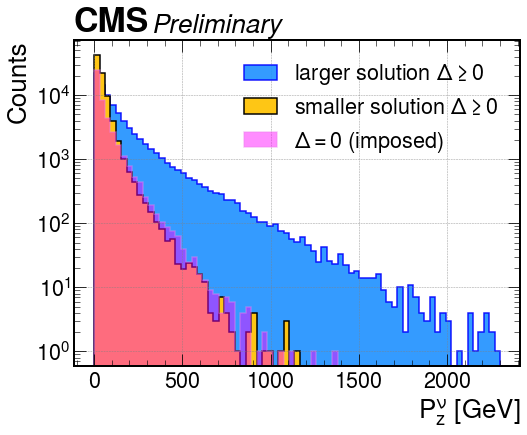

In [4]:
# plt.xkcd()
plt.figure(figsize=(8, 6))
plt.style.use(hep.style.CMS)
plt.hist(np.abs(nu_pz_good_high), bins=75, alpha=0.9,
         label=r"larger solution $\Delta \geq 0  $", range=(0, 2300), color="dodgerblue", edgecolor='blue', histtype="stepfilled", linewidth=1.5)
plt.hist(np.abs(nu_pz_good_low), bins=75, alpha=1,
         label=r"smaller solution $\Delta \geq 0$", range=(0, 2300), color=mcolors.XKCD_COLORS["xkcd:golden yellow"], histtype="stepfilled", linewidth=1.5, edgecolor="black")
plt.hist(np.abs(nu_pz_bad), bins=75, alpha=0.45,
         label=r"$\Delta=0 $ (imposed)", range=(0, 2300), color="fuchsia", edgecolor='violet', histtype="stepfilled", linewidth=1.5)
plt.legend()
plt.xlabel(r"$P_z^{\nu}$ [GeV]")
plt.ylabel("Counts")
hep.cms.text("Preliminary")
plt.yscale("log")
plt.grid(color="grey", linestyle="--", linewidth=0.5)


In [5]:
mu_pt = get("Muon_pt[:,0]")
mu_eta = get("Muon_eta[:,0]")
mu_phi = get("Muon_phi[:,0]")
met_pt = get("MET_pt")
met_phi = get("MET_phi")
mu_pt_good=mu_pt[nu_pz[2]]
mu_eta_good=mu_eta[nu_pz[2]]
mu_phi_good=mu_phi[nu_pz[2]]
met_pt_good=met_pt[nu_pz[2]]
met_phi_good=met_phi[nu_pz[2]]
mu_pt_bad=mu_pt[~nu_pz[2]]
mu_eta_bad=mu_eta[~nu_pz[2]]
mu_phi_bad=mu_phi[~nu_pz[2]]
met_pt_bad=met_pt[~nu_pz[2]]
met_phi_bad=met_phi[~nu_pz[2]]





In [6]:
Wmass_good_low = Wmass(mu_pt_good, mu_eta_good, mu_phi_good,
                       met_pt_good, met_phi_good, nu_pz_good_low)
Wmass_good_high = Wmass(mu_pt_good, mu_eta_good, mu_phi_good,
                        met_pt_good, met_phi_good, nu_pz_good_high)
Wmass_bad = Wmass(mu_pt_bad, mu_eta_bad, mu_phi_bad,
                  met_pt_bad, met_phi_bad, nu_pz_bad)


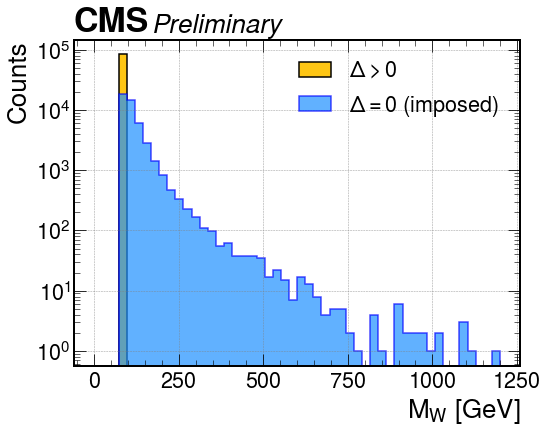

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(Wmass_good_low, bins=50, alpha=1, label="$\Delta>0$",
         range=(0, 1200), color=mcolors.XKCD_COLORS["xkcd:golden yellow"], histtype="stepfilled", linewidth=1.5, edgecolor="black")
plt.hist(Wmass_bad, bins=50, alpha=0.7, label=r"$\Delta=0$ (imposed)",
         range=(0, 1200), color="dodgerblue", edgecolor='blue', histtype="stepfilled", linewidth=1.5)


plt.legend()
plt.xlabel(r"$M_W$ [GeV]")
plt.ylabel("Counts")
hep.cms.text("Preliminary")
plt.yscale("log")
plt.grid(color="grey", linestyle="--", linewidth=0.5)


- Costruisci funzione che ritorna un branch maskato
- Ricostruisci pz neutrino eventi lhe e compara
- fai un plot con le 2 soluzioni a delta>0 e lhe
- fai un plot con soluzioni delta=0 e lhe
- fai relativi plot delle differenze dei pz tra ricostruiti e lhe

In [8]:
whereis_nu=signal.arrays("LHEPart_pdgId",library="ak")["LHEPart_pdgId"][:,[4,7]].to_numpy()
nu_eta_LHE=signal.arrays("LHEPart_eta",library="ak")["LHEPart_eta"][:,[4,7]].to_numpy()
nu_phi_LHE=signal.arrays("LHEPart_phi",library="ak")["LHEPart_phi"][:,[4,7]].to_numpy()
nu_pt_LHE=signal.arrays("LHEPart_pt",library="ak")["LHEPart_pt"][:,[4,7]].to_numpy()
nu_LHEmask=np.bitwise_or(whereis_nu==14,whereis_nu==-14)

In [9]:
# good means delta>=0, bad means delta=0 (imposed)


nu_phi_LHE=nu_phi_LHE[nu_LHEmask]
nu_phi_LHE_good=nu_phi_LHE[nu_pz[2]]
nu_phi_LHE_bad=nu_phi_LHE[~nu_pz[2]]

nu_pt_LHE = nu_pt_LHE[nu_LHEmask]
nu_pt_LHE_good=nu_pt_LHE[nu_pz[2]]
nu_pt_LHE_bad=nu_pt_LHE[~nu_pz[2]]

nu_eta_LHE = nu_eta_LHE[nu_LHEmask]
nu_eta_LHE_good=nu_eta_LHE[nu_pz[2]]
nu_eta_LHE_bad=nu_eta_LHE[~nu_pz[2]]


nu_pz_LHE = nu_pt_LHE*np.sinh(nu_eta_LHE)
nu_pz_LHE_good = nu_pz_LHE[nu_pz[2]]
nu_pz_LHE_bad = nu_pz_LHE[~nu_pz[2]]


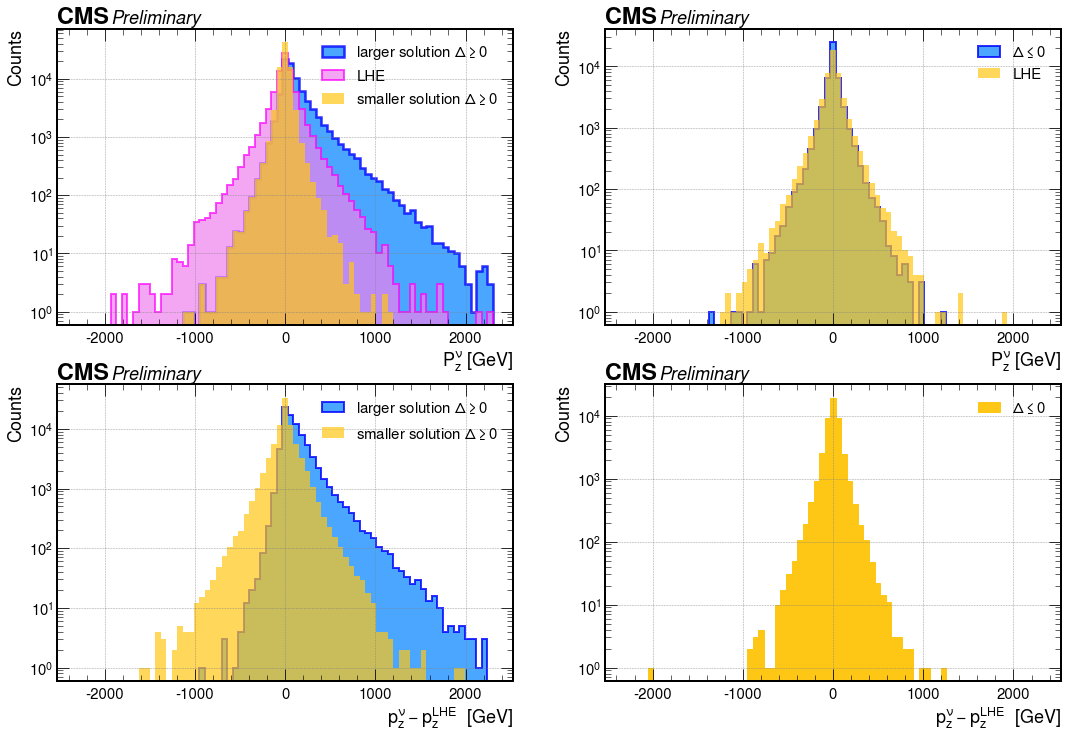

In [10]:
plt.figure(figsize=(18, 12))
mpl.rc("font", size=18)
plt.subplot(2,2,1)

plt.hist(nu_pz_good_high, bins=75, alpha=0.8,
         label=r"larger solution $\Delta \geq 0  $", range=(-2300, 2300), color="dodgerblue", edgecolor='blue', histtype="stepfilled", linewidth=2.5)

plt.hist(nu_pz_LHE_good, bins=75, alpha=0.7,
         label=r"LHE", range=(-2300, 2300), color="violet", edgecolor='fuchsia', histtype="stepfilled", linewidth=2)
plt.hist(nu_pz_good_low, bins=75, alpha=0.7,
         label=r"smaller solution $\Delta \geq 0$", range=(-2300, 2300), color=mcolors.XKCD_COLORS["xkcd:golden yellow"], histtype="stepfilled", linewidth=0, edgecolor=mcolors.XKCD_COLORS["xkcd:golden yellow"])

plt.legend()
plt.xlabel(r"$P_z^{\nu}$ [GeV]")
plt.ylabel("Counts")
hep.cms.text("Preliminary")
plt.yscale("log")
plt.grid(color="grey", linestyle="--", linewidth=0.5)

plt.subplot(2, 2, 3)

plt.hist(nu_pz_good_high-nu_pz_LHE_good, bins=75, alpha=0.8,
         label=r"larger solution $\Delta \geq 0$", range=(-2300, 2300), color="dodgerblue", edgecolor='blue', histtype="stepfilled", linewidth=2)
plt.hist(nu_pz_good_low-nu_pz_LHE_good, bins=75, alpha=0.7,
         label=r"smaller solution $\Delta \geq 0$", range=(-2300, 2300), color=mcolors.XKCD_COLORS["xkcd:golden yellow"], histtype="stepfilled", linewidth=0, edgecolor=mcolors.XKCD_COLORS["xkcd:golden yellow"])

plt.legend()
plt.xlabel(r"$p_z^{\nu}-p_z^{LHE}$  [GeV]")
plt.ylabel("Counts")
hep.cms.text("Preliminary")
plt.yscale("log")
plt.grid(color="grey", linestyle="--", linewidth=0.5)


plt.subplot(2, 2, 2)

plt.hist(nu_pz_bad, bins=75, alpha=0.8,
         label=r"$\Delta \leq 0  $", range=(-2300, 2300), color="dodgerblue", edgecolor='blue', histtype="stepfilled", linewidth=2)

plt.hist(nu_pz_LHE_bad, bins=75, alpha=0.7,
         label=r"LHE", range=(-2300, 2300), color=mcolors.XKCD_COLORS["xkcd:golden yellow"], histtype="stepfilled", linewidth=0, edgecolor=mcolors.XKCD_COLORS["xkcd:golden yellow"])

plt.legend()
plt.xlabel(r"$P_z^{\nu}$ [GeV]")
plt.ylabel("Counts")
hep.cms.text("Preliminary")
plt.yscale("log")
plt.grid(color="grey", linestyle="--", linewidth=0.5)


plt.subplot(2, 2, 4)


plt.hist(nu_pz_bad-nu_pz_LHE_bad, bins=75, alpha=1,
         label=r"$\Delta \leq 0$", range=(-2300, 2300), color=mcolors.XKCD_COLORS["xkcd:golden yellow"], histtype="stepfilled", linewidth=1, edgecolor=mcolors.XKCD_COLORS["xkcd:golden yellow"])

plt.legend()
plt.xlabel(r"$p_z^{\nu}-p_z^{LHE}$  [GeV]")
plt.ylabel("Counts")
hep.cms.text("Preliminary")
plt.yscale("log")
plt.grid(color="grey", linestyle="--", linewidth=0.5)


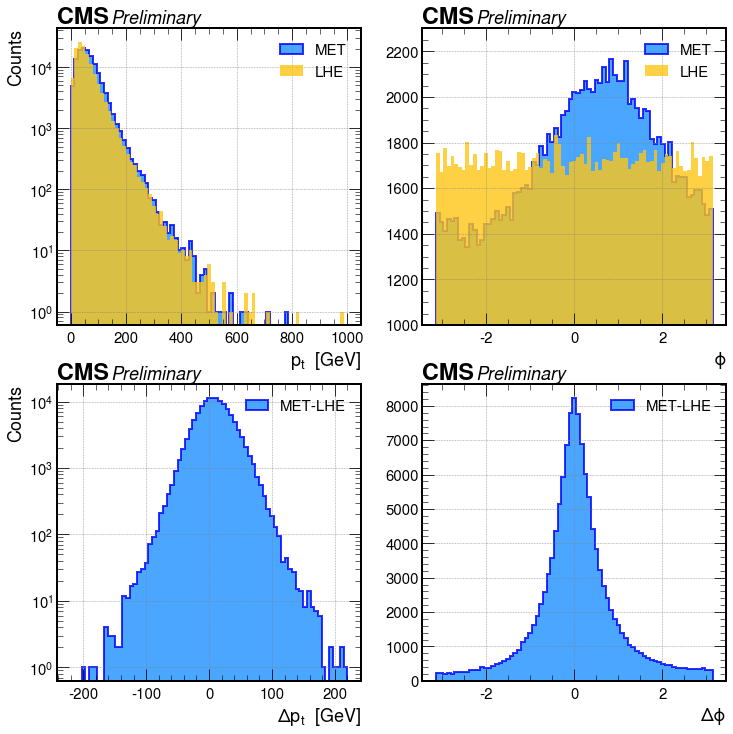

In [13]:
plt.figure(figsize=(12,12))
mpl.rc("font",size=18)
plt.subplot(2,2,1)
plt.hist(met_pt, bins=75, alpha=0.8,
         label=r"MET", range=(0,1000), color="dodgerblue", edgecolor='blue', histtype="stepfilled", linewidth=2)
plt.hist(nu_pt_LHE, bins=75, alpha=0.8,
         label=r"LHE", range=(0,1000), color=mcolors.XKCD_COLORS["xkcd:golden yellow"], histtype="stepfilled", linewidth=0, edgecolor=mcolors.XKCD_COLORS["xkcd:golden yellow"])

plt.legend()
plt.xlabel(r"$p_t$  [GeV]")
plt.ylabel("Counts")
hep.cms.text("Preliminary")
plt.yscale("log")
plt.grid(color="grey", linestyle="--", linewidth=0.5)


plt.subplot(2, 2, 3)

plt.hist(met_pt-nu_pt_LHE, bins=75, alpha=0.8,
         label=r"MET-LHE", range=(-220,220), color="dodgerblue", edgecolor='blue', histtype="stepfilled", linewidth=2)

plt.legend()
plt.xlabel(r"$\Delta p_t$  [GeV]")
plt.ylabel("Counts")
hep.cms.text("Preliminary")
plt.yscale("log")
plt.grid(color="grey", linestyle="--", linewidth=0.5)



plt.subplot(2, 2, 2)
plt.hist(met_phi, bins=75, alpha=0.8,
         label=r"MET", range=(-3.14,3.14), color="dodgerblue", edgecolor='blue', histtype="stepfilled", linewidth=2)
plt.hist(nu_phi_LHE, bins=75, alpha=0.8,
         label=r"LHE", range=(-3.14,3.14), color=mcolors.XKCD_COLORS["xkcd:golden yellow"], histtype="stepfilled", linewidth=0, edgecolor=mcolors.XKCD_COLORS["xkcd:golden yellow"])

plt.legend()
plt.xlabel(r"$\phi$")

plt.ylim(1000,2300)
hep.cms.text("Preliminary")

plt.grid(color="grey", linestyle="--", linewidth=0.5)

plt.subplot(2, 2, 4)

plt.hist(deltaPhi(met_phi,nu_phi_LHE), bins=75, alpha=0.8,
         label=r"MET-LHE", range=(-3.14, 3.14), color="dodgerblue", edgecolor='blue', histtype="stepfilled", linewidth=2)

plt.legend()
plt.xlabel(r"$\Delta \phi$")
hep.cms.text("Preliminary")
plt.grid(color="grey", linestyle="--", linewidth=0.5)
